# Setup


In [1]:
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install gdown==4.6.0
!gdown "1KOmSrlGcC50PjkvRVbyb_WoWHVql06J-&confirm=t"

  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-mnoyv0px
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-mnoyv0px
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit f757e72b02fefe20e710b3be50b8c4ebe585db7b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.4.0-py3-none-any.whl size=1098115 sha256=0cf25e6abaa3ed3e3a1a70a410d8ee4122b8a3ae14c78861de5cfee985c1e0c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-cu1_3w7x/wheels/d3/78/eb/9e26525b948d19533f1688fb6c209cec8a0ba793d39b49ae8f
Successfully built torch_geometric
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Downloading...
From: https://drive.google.com/uc?i

In [2]:
import os
os.mkdir("/content/data/")
os.mkdir("/content/data/UPFD/")
os.mkdir("/content/data/UPFD/politifact/")
os.mkdir("/content/data/UPFD/politifact/raw")
!unzip politifact.zip -d "/content/data/UPFD/politifact/raw"

Archive:  politifact.zip
  inflating: /content/data/UPFD/politifact/raw/A.txt  
  inflating: /content/data/UPFD/politifact/raw/graph_labels.npy  
  inflating: /content/data/UPFD/politifact/raw/new_bert_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/new_content_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/new_profile_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/new_spacy_feature.npz  
  inflating: /content/data/UPFD/politifact/raw/node_graph_id.npy  
  inflating: /content/data/UPFD/politifact/raw/test_idx.npy  
  inflating: /content/data/UPFD/politifact/raw/train_idx.npy  
  inflating: /content/data/UPFD/politifact/raw/val_idx.npy  


In [1]:
import argparse
import os.path as osp

import torch
import torch.nn.functional as F
from torch.nn import Linear

from torch_geometric.datasets import UPFD
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, global_max_pool
from torch_geometric.transforms import ToUndirected

In [34]:
argdataset = 'politifact' #politifact
argfeature = 'spacy' #spacy, bert, content, profile

path = '/content/data/UPFD'
train_dataset = UPFD(path, argdataset, argfeature, 'train', ToUndirected())
val_dataset = UPFD(path, argdataset, argfeature, 'val', ToUndirected())
test_dataset = UPFD(path, argdataset, argfeature, 'test', ToUndirected())

len_dataset = UPFD(path, argdataset, 'profile', 'train', ToUndirected())

Processing...
Done!


In [35]:
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color,cmap='Set1')
    plt.show()

In [76]:
G = nx.Graph()
for root_id in range(len(train_dataset)):
    G.add_node(root_id, x=train_dataset[root_id].x[0], y=train_dataset[root_id].y[0])

In [77]:
import torch.nn.functional as F
import torch
for root_id in range(len(train_dataset)-1):
    for second_id in range(root_id+1,len(train_dataset)):
      #css = F.cosine_similarity(train_dataset[root_id].x[0],train_dataset[second_id].x[0],dim = 0)
      dist = (len_dataset[root_id].x[0] - len_dataset[second_id].x[0]).pow(2).sum(0).sqrt()
      if dist < 0.01:
        G.add_edge(root_id, second_id, weight=1)

In [78]:
from torch_geometric.utils.convert import from_networkx
ds_mock = from_networkx(G)

In [61]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index).relu()
        h = self.lin2(h)
        return h.log_softmax(dim=-1)

In [72]:
test_G = nx.Graph()
for root_id in range(len(test_dataset)):
    test_G.add_node(root_id, x=test_dataset[root_id].x[0], y=test_dataset[root_id].y[0])

test_ds = from_networkx(test_G)

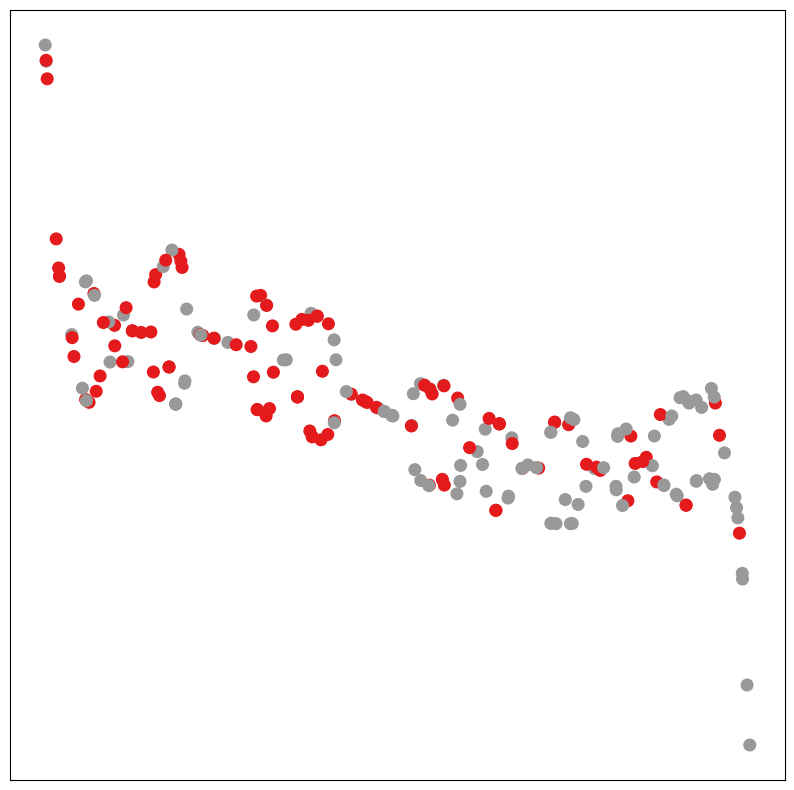

In [73]:
model_init = Net(in_channels = 300, hidden_channels=128, out_channels = 2)
model_init.eval()

out = model_init(test_ds.x, test_ds.edge_index)
visualize(out, color=test_ds.y)

In [79]:
model = Net(in_channels = 300, hidden_channels=128, out_channels = 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(ds_mock.x, ds_mock.edge_index)  # Perform a single forward pass.
      loss = criterion(out, ds_mock.y)  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 501):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 0.6851
Epoch: 002, Loss: 0.6409
Epoch: 003, Loss: 0.5918
Epoch: 004, Loss: 0.5406
Epoch: 005, Loss: 0.4876
Epoch: 006, Loss: 0.4402
Epoch: 007, Loss: 0.3972
Epoch: 008, Loss: 0.3590
Epoch: 009, Loss: 0.3270
Epoch: 010, Loss: 0.2943
Epoch: 011, Loss: 0.2636
Epoch: 012, Loss: 0.2345
Epoch: 013, Loss: 0.2039
Epoch: 014, Loss: 0.1757
Epoch: 015, Loss: 0.1517
Epoch: 016, Loss: 0.1296
Epoch: 017, Loss: 0.1119
Epoch: 018, Loss: 0.0982
Epoch: 019, Loss: 0.0852
Epoch: 020, Loss: 0.0751
Epoch: 021, Loss: 0.0652
Epoch: 022, Loss: 0.0567
Epoch: 023, Loss: 0.0485
Epoch: 024, Loss: 0.0415
Epoch: 025, Loss: 0.0354
Epoch: 026, Loss: 0.0301
Epoch: 027, Loss: 0.0257
Epoch: 028, Loss: 0.0220
Epoch: 029, Loss: 0.0190
Epoch: 030, Loss: 0.0167
Epoch: 031, Loss: 0.0147
Epoch: 032, Loss: 0.0132
Epoch: 033, Loss: 0.0119
Epoch: 034, Loss: 0.0111
Epoch: 035, Loss: 0.0103
Epoch: 036, Loss: 0.0098
Epoch: 037, Loss: 0.0094
Epoch: 038, Loss: 0.0091
Epoch: 039, Loss: 0.0089
Epoch: 040, Loss: 0.0087


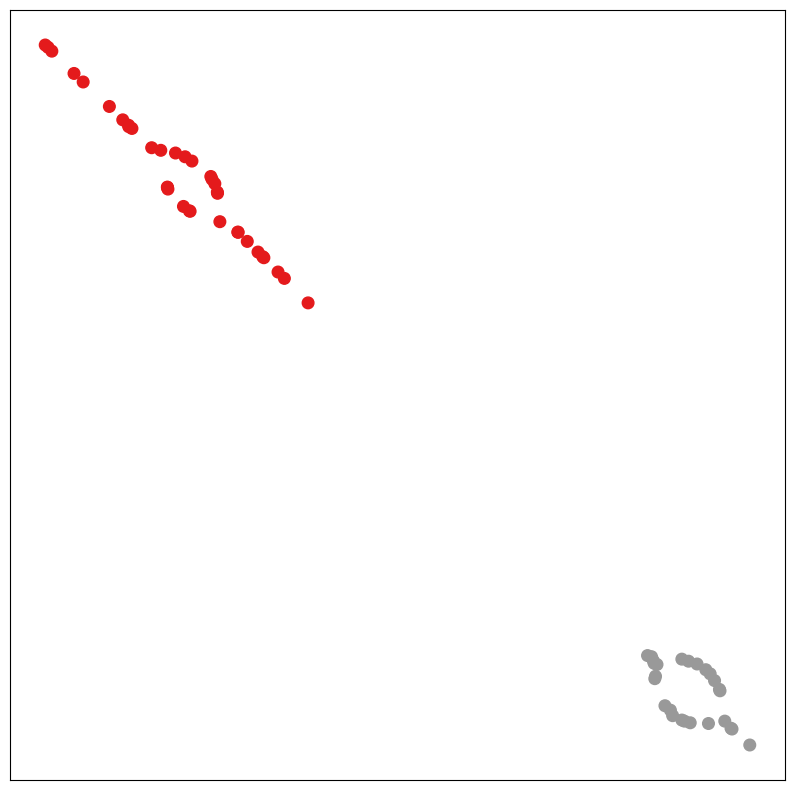

In [43]:
model.eval()
out = model(ds_mock.x, ds_mock.edge_index)
visualize(out, color=ds_mock.y)

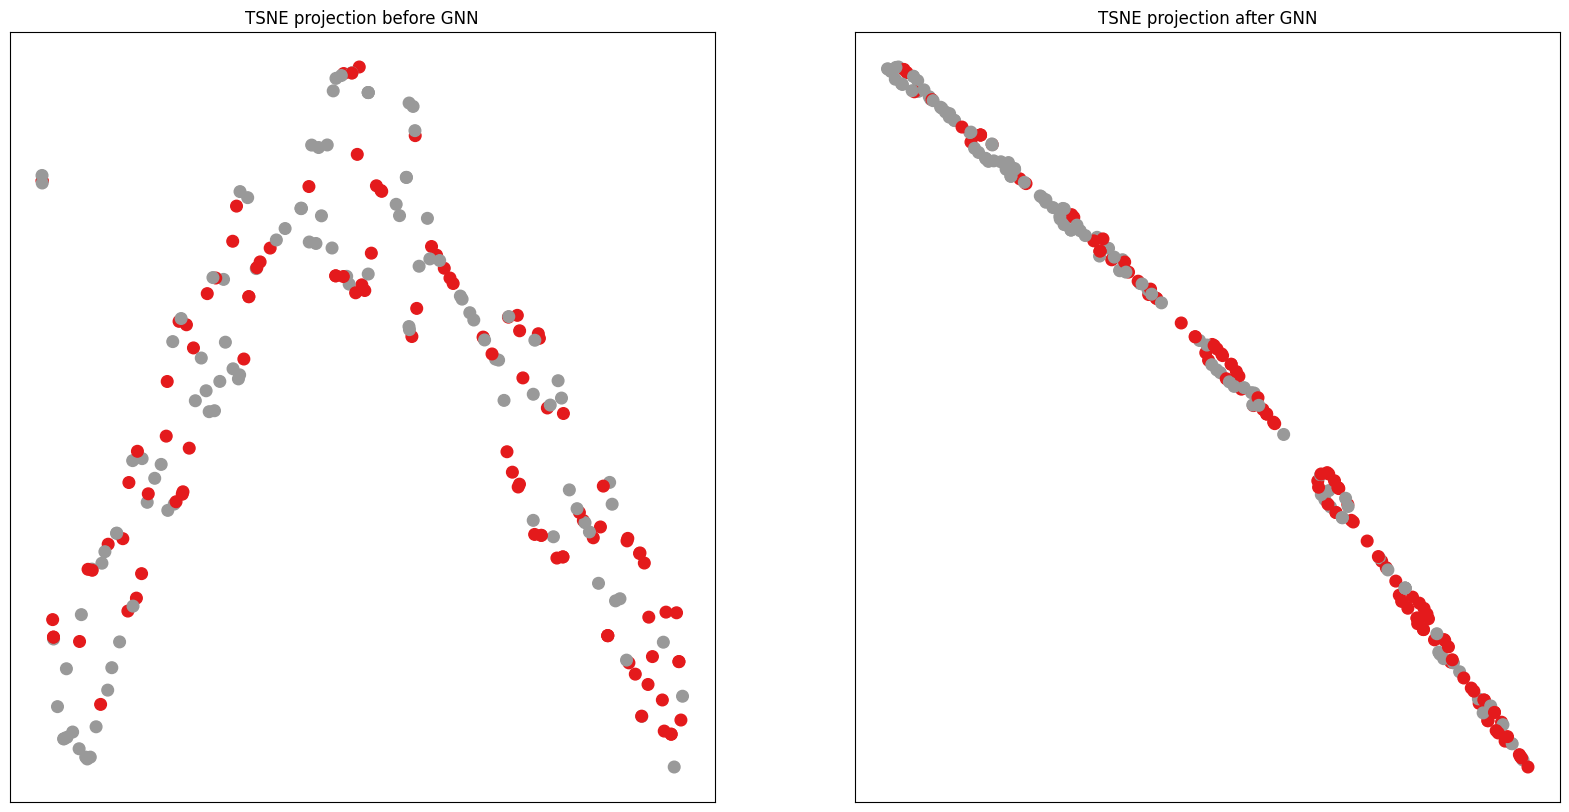

In [44]:
def visualize_double(data, model_init, model_out):
    model_init.eval()
    model_out.eval()
    out_init = model_init(data.x, data.edge_index)
    out = model_out(data.x, data.edge_index)
    color = data.y
    z1 = TSNE(n_components=2).fit_transform(out_init.detach().cpu().numpy())
    z2 = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(20,10))

    plt.subplot(1,2,1)
    plt.title("TSNE projection before GNN")
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z1[:, 0], z1[:, 1], s=70, c=color,cmap='Set1')

    plt.subplot(1,2,2)
    plt.title("TSNE projection after GNN")
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z2[:, 0], z2[:, 1], s=70, c=color,cmap='Set1')
    plt.show()

visualize_double(test_ds,model_init, model)

In [80]:
def test(data,model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_incorrect = (torch.abs(pred - data.y)).sum()
      test_acc = 1 - test_incorrect / data.y.shape[0]
      return test_acc

test(test_ds,model)

tensor(0.7828)